# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.25KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

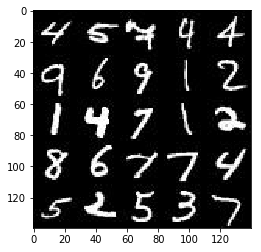

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

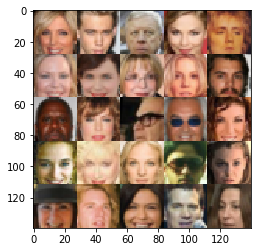

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it 4096
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2

    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 7, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, beta1=0.5):
        tf.reset_default_graph()

        self.out_channel_dim = real_size[2]

        self.input_real, self.input_z, _ = model_inputs(real_size[0], real_size[1], real_size[2], z_size)

        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, self.out_channel_dim)

        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
        
        
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 20

    net = GAN(data_shape[1:], z_dim, learning_rate, beta1=beta1)

    saver = tf.train.Saver()

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # batch_images = batch_images.reshape((batch_size, 28, 28, 1))
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 9, net.input_z, net.out_channel_dim, data_image_mode)
                    # gen_samples = sess.run(
                    #     generator(net.input_z, net.out_channel_dim, is_train=False),
                    #     feed_dict={net.input_z: sample_z})
                    # samples.append(gen_samples)
                    # view_samples("{}".format(steps), -1, samples, 6, 12, figsize=figsize)
                    # plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1662... Generator Loss: 2.2687
Epoch 1/2... Discriminator Loss: 0.0703... Generator Loss: 3.3830


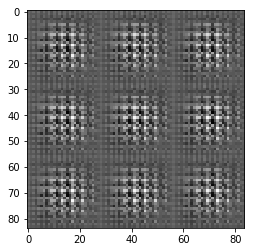

Epoch 1/2... Discriminator Loss: 0.0646... Generator Loss: 3.0979
Epoch 1/2... Discriminator Loss: 0.0157... Generator Loss: 4.5777


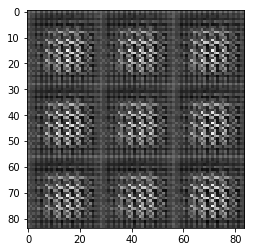

Epoch 1/2... Discriminator Loss: 0.0419... Generator Loss: 5.7393
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 0.7405


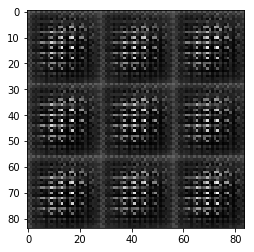

Epoch 1/2... Discriminator Loss: 0.0924... Generator Loss: 3.6406
Epoch 1/2... Discriminator Loss: 0.1944... Generator Loss: 12.5496


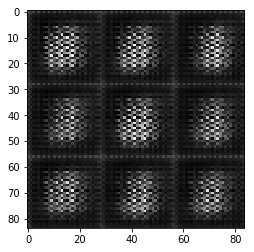

Epoch 1/2... Discriminator Loss: 0.6705... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 0.1389... Generator Loss: 3.5668


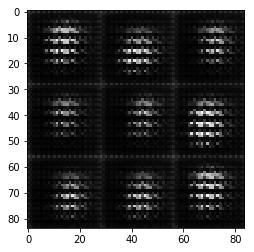

Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 1.2224
Epoch 1/2... Discriminator Loss: 0.1774... Generator Loss: 3.3530


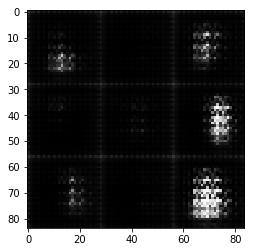

Epoch 1/2... Discriminator Loss: 0.2256... Generator Loss: 2.5277
Epoch 1/2... Discriminator Loss: 0.4438... Generator Loss: 1.4086


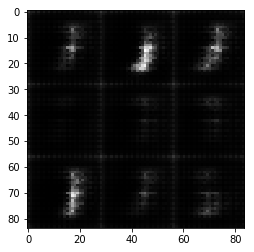

Epoch 1/2... Discriminator Loss: 0.2764... Generator Loss: 2.5376
Epoch 1/2... Discriminator Loss: 0.2400... Generator Loss: 2.8132


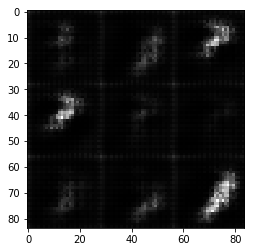

Epoch 1/2... Discriminator Loss: 0.5176... Generator Loss: 3.9651
Epoch 1/2... Discriminator Loss: 0.3891... Generator Loss: 1.9903


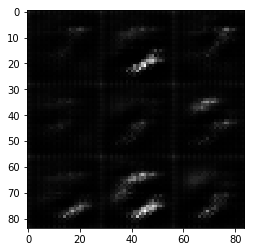

Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 3.3756
Epoch 1/2... Discriminator Loss: 0.4741... Generator Loss: 4.6683


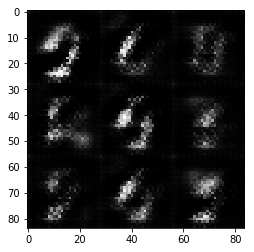

Epoch 1/2... Discriminator Loss: 1.5649... Generator Loss: 0.3312
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 1.5991


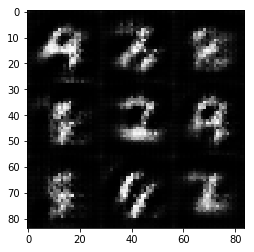

Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 2.2773
Epoch 1/2... Discriminator Loss: 0.6754... Generator Loss: 1.4384


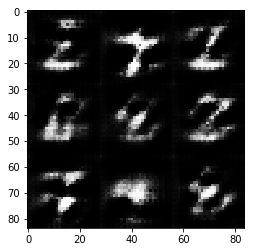

Epoch 1/2... Discriminator Loss: 0.4539... Generator Loss: 2.6134
Epoch 1/2... Discriminator Loss: 0.6261... Generator Loss: 1.1352


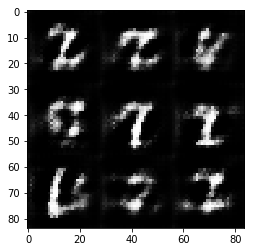

Epoch 1/2... Discriminator Loss: 0.8544... Generator Loss: 1.0130
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 1.2149


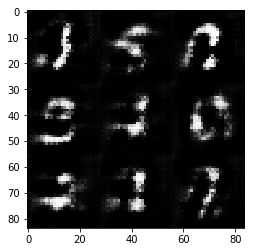

Epoch 1/2... Discriminator Loss: 0.8877... Generator Loss: 0.9632
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.5917


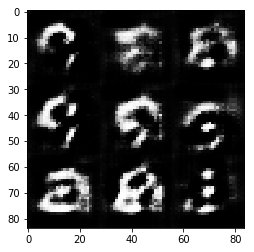

Epoch 1/2... Discriminator Loss: 0.5944... Generator Loss: 1.9821
Epoch 1/2... Discriminator Loss: 0.5812... Generator Loss: 2.0757


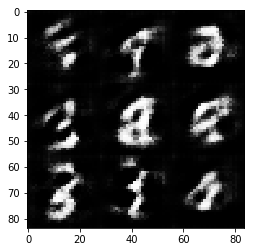

Epoch 1/2... Discriminator Loss: 0.6714... Generator Loss: 1.3731
Epoch 1/2... Discriminator Loss: 1.5162... Generator Loss: 3.3934


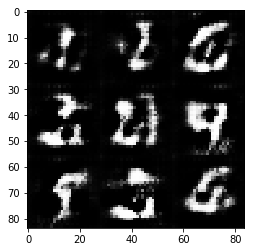

Epoch 1/2... Discriminator Loss: 0.7776... Generator Loss: 1.1985
Epoch 1/2... Discriminator Loss: 0.8503... Generator Loss: 0.9660


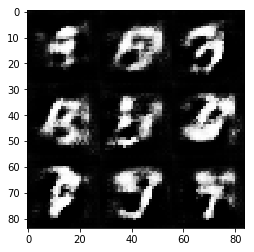

Epoch 1/2... Discriminator Loss: 0.9031... Generator Loss: 2.2960
Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 1.1296


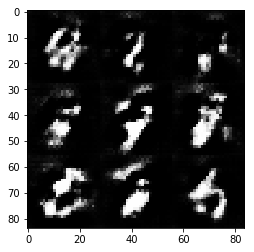

Epoch 1/2... Discriminator Loss: 0.9596... Generator Loss: 1.8104
Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 1.1874


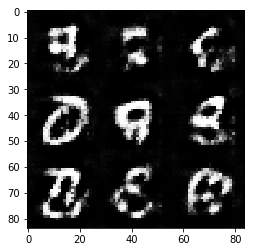

Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.8201
Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 0.9040


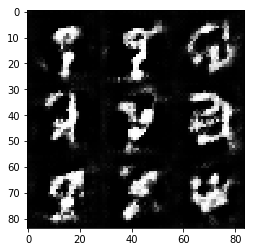

Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 0.9145


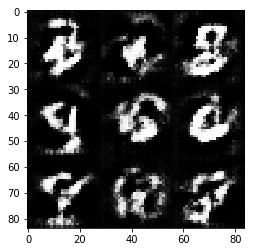

Epoch 1/2... Discriminator Loss: 0.9538... Generator Loss: 1.7771
Epoch 1/2... Discriminator Loss: 0.8661... Generator Loss: 1.2909


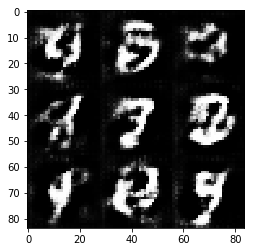

Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 0.8968... Generator Loss: 1.4708


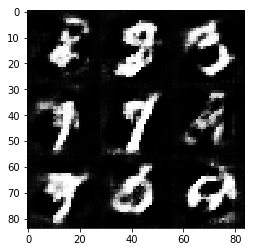

Epoch 2/2... Discriminator Loss: 0.9920... Generator Loss: 0.7142
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 0.5495


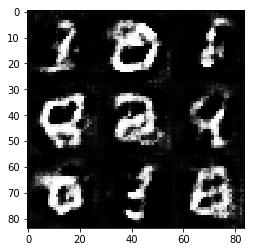

Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 2.1977
Epoch 2/2... Discriminator Loss: 0.7231... Generator Loss: 1.1477


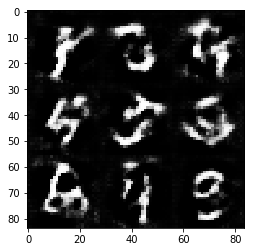

Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 0.7067
Epoch 2/2... Discriminator Loss: 0.7699... Generator Loss: 1.1124


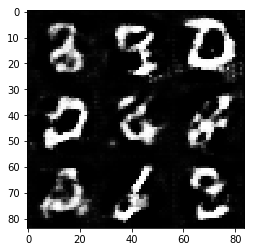

Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 1.8563
Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 1.3579


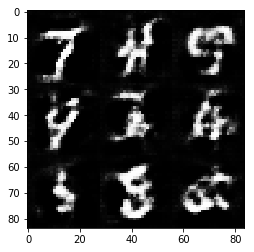

Epoch 2/2... Discriminator Loss: 0.8990... Generator Loss: 2.1239
Epoch 2/2... Discriminator Loss: 0.8275... Generator Loss: 0.9670


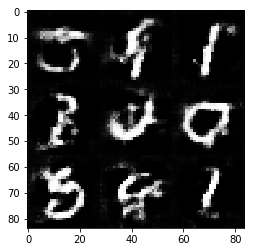

Epoch 2/2... Discriminator Loss: 0.8803... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 0.8010... Generator Loss: 1.5983


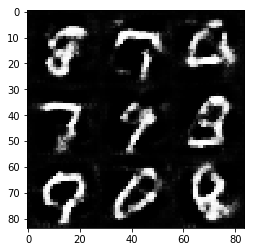

Epoch 2/2... Discriminator Loss: 0.8091... Generator Loss: 0.9090
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 1.8536


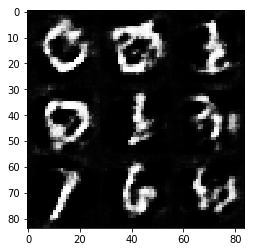

Epoch 2/2... Discriminator Loss: 0.7780... Generator Loss: 1.4196
Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 0.9881


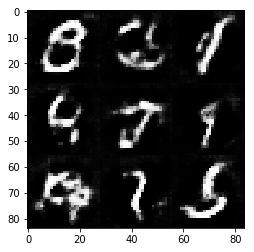

Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 0.7582
Epoch 2/2... Discriminator Loss: 0.9489... Generator Loss: 0.7699


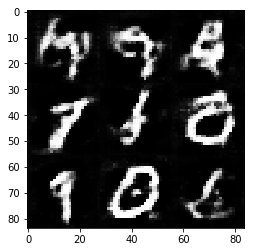

Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 0.4908
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.7229


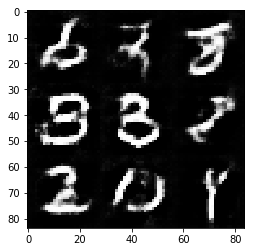

Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 0.8043... Generator Loss: 1.2838


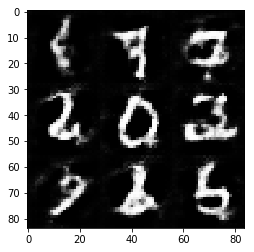

Epoch 2/2... Discriminator Loss: 0.9979... Generator Loss: 2.1842
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.0451


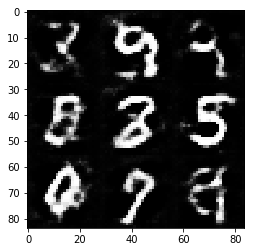

Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 0.5453
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 0.7288


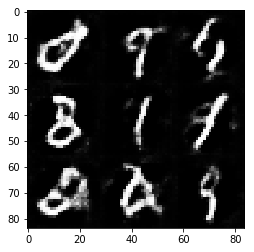

Epoch 2/2... Discriminator Loss: 0.7948... Generator Loss: 1.0719
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 1.9681


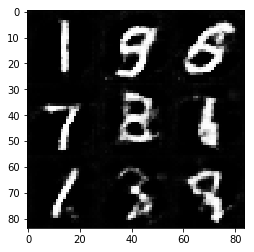

Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 1.1686
Epoch 2/2... Discriminator Loss: 0.9618... Generator Loss: 1.7054


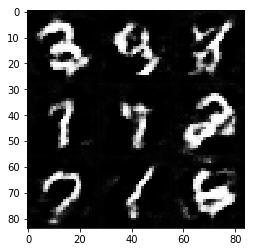

Epoch 2/2... Discriminator Loss: 0.7724... Generator Loss: 1.4545
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 0.9100


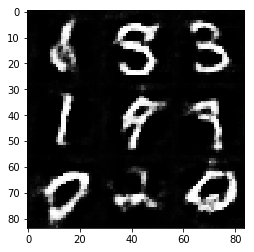

Epoch 2/2... Discriminator Loss: 0.7982... Generator Loss: 1.1813
Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 1.5171


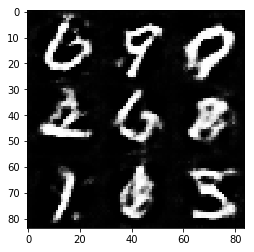

Epoch 2/2... Discriminator Loss: 0.8397... Generator Loss: 1.7738
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 1.6170


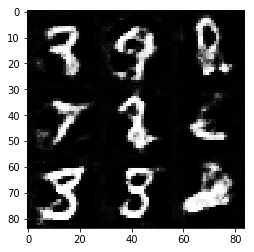

Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 1.2669... Generator Loss: 2.5984


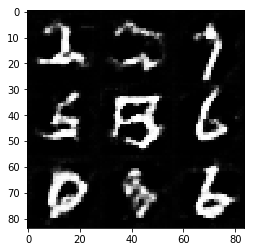

Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 0.6055
Epoch 2/2... Discriminator Loss: 0.7736... Generator Loss: 1.0035


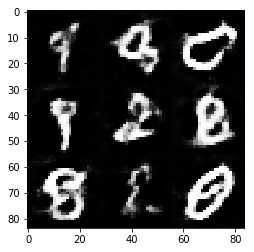

Epoch 2/2... Discriminator Loss: 0.9753... Generator Loss: 0.6359
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.2869


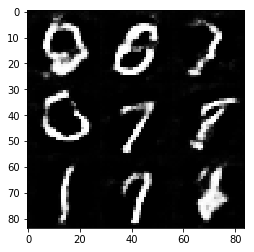

Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 1.5016
Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 0.9028


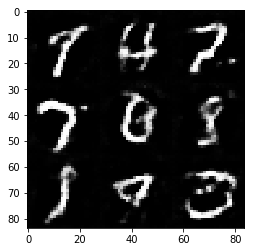

Epoch 2/2... Discriminator Loss: 0.8909... Generator Loss: 0.7397


IndexError: list index out of range

In [12]:
batch_size = 128

z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.4784... Generator Loss: 1.7669
Epoch 1/2... Discriminator Loss: 0.1973... Generator Loss: 2.9355


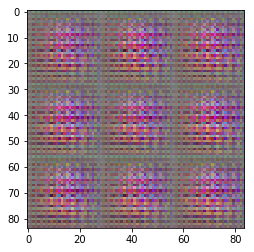

Epoch 1/2... Discriminator Loss: 0.1336... Generator Loss: 2.8210
Epoch 1/2... Discriminator Loss: 0.2661... Generator Loss: 8.5356


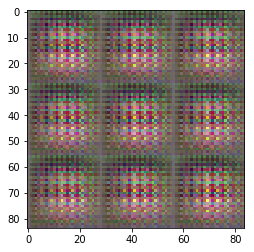

Epoch 1/2... Discriminator Loss: 3.1363... Generator Loss: 0.0461
Epoch 1/2... Discriminator Loss: 0.6028... Generator Loss: 8.6458


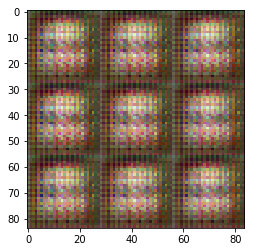

Epoch 1/2... Discriminator Loss: 0.7167... Generator Loss: 0.8883
Epoch 1/2... Discriminator Loss: 0.3236... Generator Loss: 7.6249


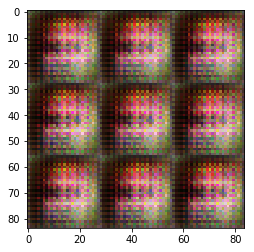

Epoch 1/2... Discriminator Loss: 0.5997... Generator Loss: 1.4347
Epoch 1/2... Discriminator Loss: 0.2766... Generator Loss: 3.0884


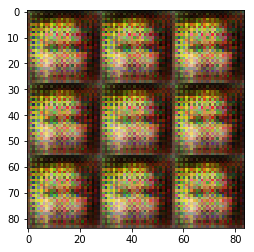

Epoch 1/2... Discriminator Loss: 0.2318... Generator Loss: 2.5384
Epoch 1/2... Discriminator Loss: 0.4885... Generator Loss: 2.1580


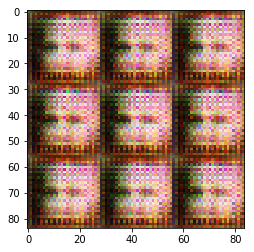

Epoch 1/2... Discriminator Loss: 0.2962... Generator Loss: 2.5585
Epoch 1/2... Discriminator Loss: 0.2703... Generator Loss: 3.4827


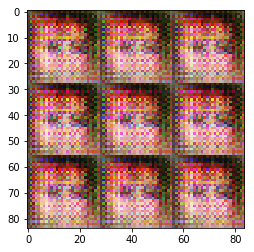

Epoch 1/2... Discriminator Loss: 0.2367... Generator Loss: 2.3179
Epoch 1/2... Discriminator Loss: 0.1987... Generator Loss: 2.4101


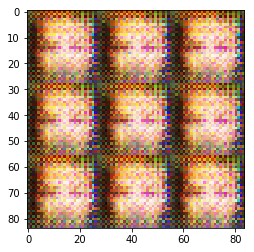

Epoch 1/2... Discriminator Loss: 0.2200... Generator Loss: 2.5405
Epoch 1/2... Discriminator Loss: 0.1619... Generator Loss: 2.5572


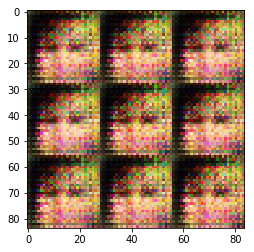

Epoch 1/2... Discriminator Loss: 0.2414... Generator Loss: 2.3468
Epoch 1/2... Discriminator Loss: 0.1375... Generator Loss: 2.9947


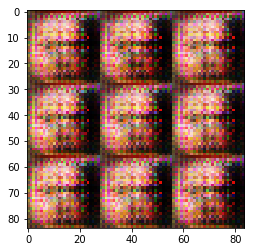

Epoch 1/2... Discriminator Loss: 0.1874... Generator Loss: 2.3938
Epoch 1/2... Discriminator Loss: 0.4007... Generator Loss: 1.7500


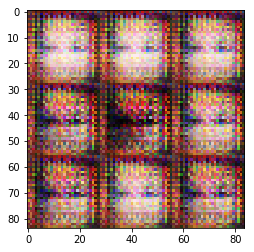

Epoch 1/2... Discriminator Loss: 0.6620... Generator Loss: 1.1450
Epoch 1/2... Discriminator Loss: 0.6504... Generator Loss: 1.0913


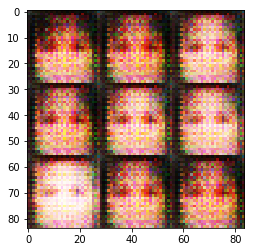

Epoch 1/2... Discriminator Loss: 0.3473... Generator Loss: 2.1339
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 0.4373


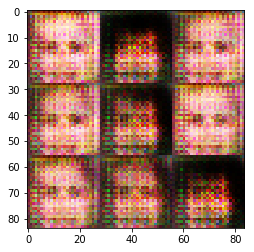

Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 2.3957
Epoch 1/2... Discriminator Loss: 0.4447... Generator Loss: 2.0119


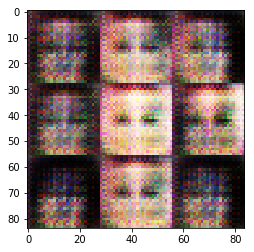

Epoch 1/2... Discriminator Loss: 0.4971... Generator Loss: 2.1223
Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 1.3159


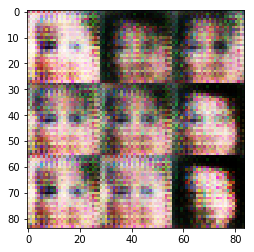

Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.3250
Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 0.8913


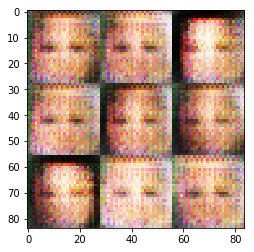

Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 0.9890
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 0.7072


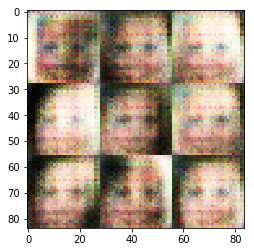

Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 1.1039... Generator Loss: 1.2055


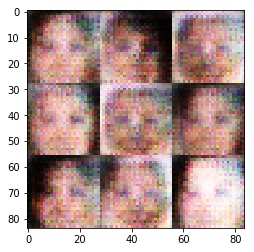

Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 1.1773
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 1.2166


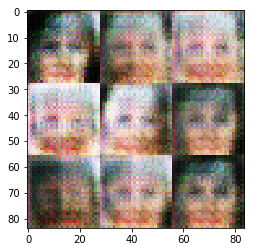

Epoch 1/2... Discriminator Loss: 1.6478... Generator Loss: 0.7480
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 1.8891


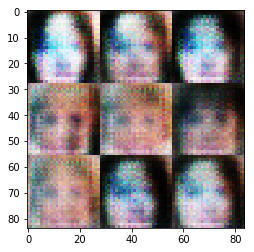

Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 1.1491
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 1.2267


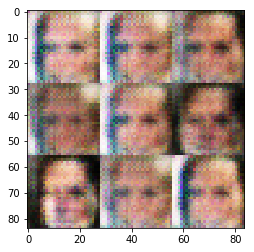

Epoch 1/2... Discriminator Loss: 1.6184... Generator Loss: 0.6550
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.8493


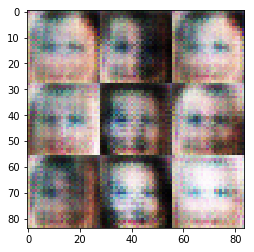

Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 0.9331
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.8560


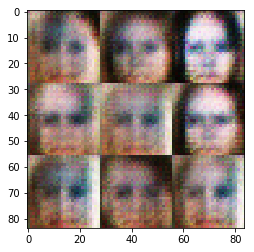

Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.8805
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 0.9598


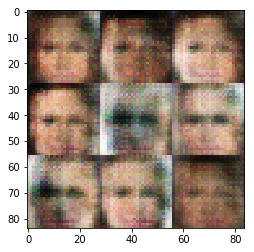

Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 0.8990... Generator Loss: 1.0324


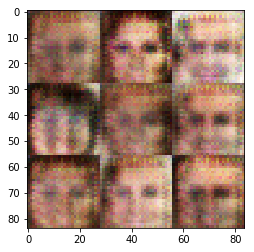

Epoch 1/2... Discriminator Loss: 0.9315... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 0.9500


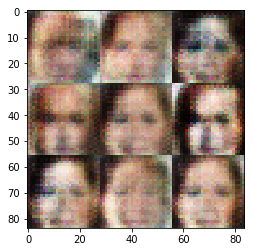

Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 1.0240
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.8696


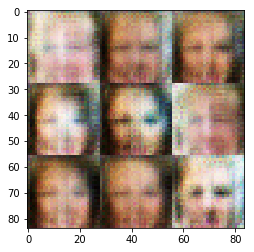

Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.7229
Epoch 1/2... Discriminator Loss: 1.0521... Generator Loss: 0.9303


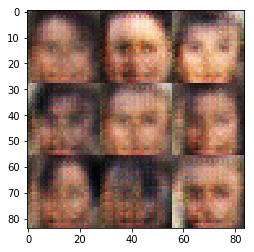

Epoch 1/2... Discriminator Loss: 0.8813... Generator Loss: 1.0613
Epoch 1/2... Discriminator Loss: 0.9738... Generator Loss: 1.1545


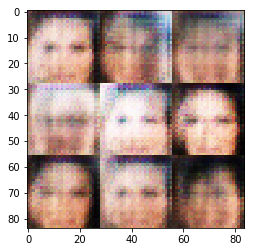

Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.8849
Epoch 1/2... Discriminator Loss: 1.3356... Generator Loss: 1.0985


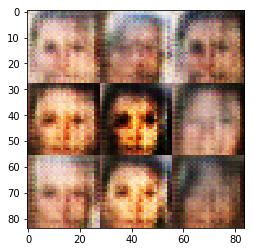

Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 1.0053
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 1.6342


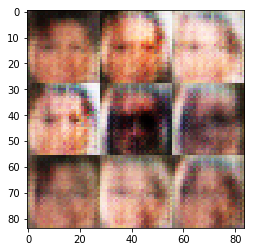

Epoch 1/2... Discriminator Loss: 0.8504... Generator Loss: 1.7858
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 0.7066


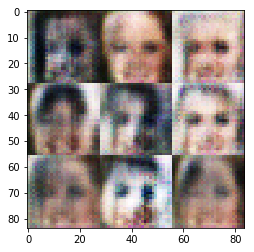

Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 0.9309
Epoch 1/2... Discriminator Loss: 0.8322... Generator Loss: 1.2996


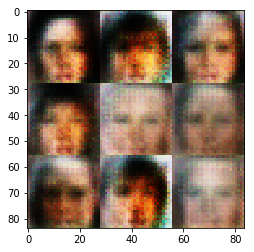

Epoch 1/2... Discriminator Loss: 0.8957... Generator Loss: 1.1253
Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 1.0354


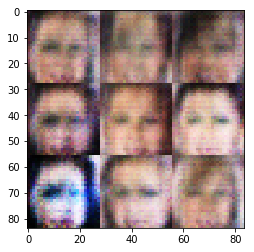

Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 1.2009
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 0.8807


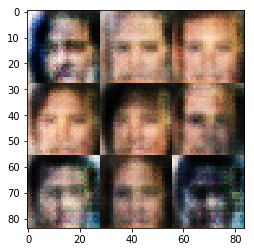

Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.5455
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.9092


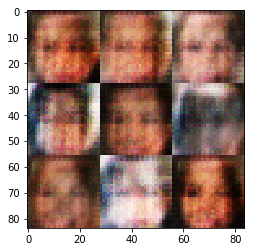

Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 1.5351
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.9516


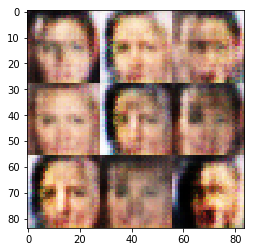

Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 0.9742


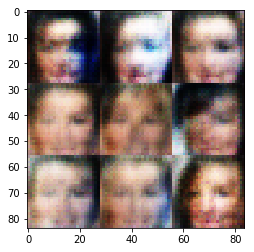

Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 1.3546... Generator Loss: 0.8323


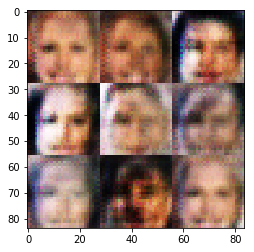

Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.7593
Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 0.8624


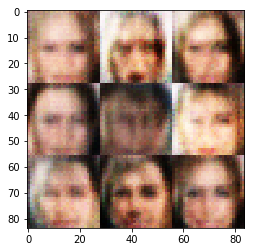

Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 1.0068
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.8826


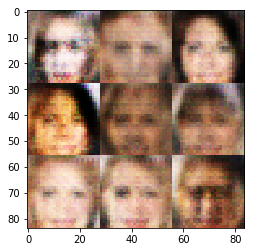

Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.8794


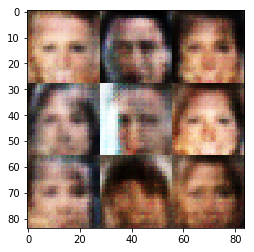

Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 1.2179
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 1.0342


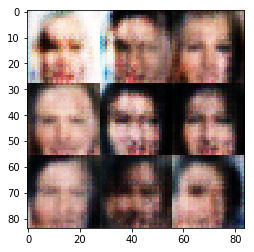

Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 1.4718
Epoch 1/2... Discriminator Loss: 1.1696... Generator Loss: 0.9171


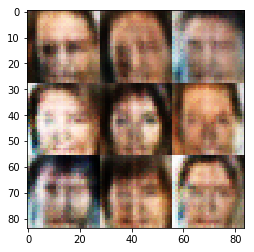

Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 1.2648
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 0.8458


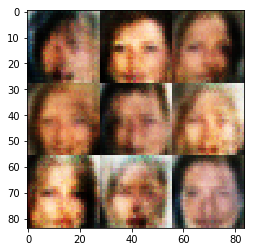

Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.4888
Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.4992


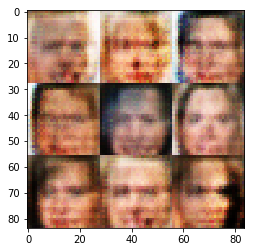

Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.9150
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.7109


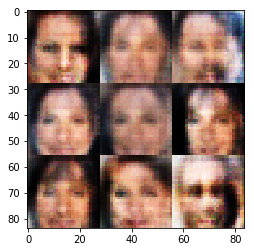

Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 1.0786
Epoch 1/2... Discriminator Loss: 1.3430... Generator Loss: 0.6637


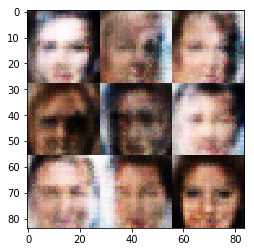

Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 1.2210
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 0.8089


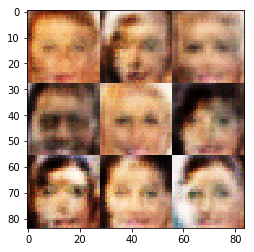

Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 0.8346... Generator Loss: 1.3075


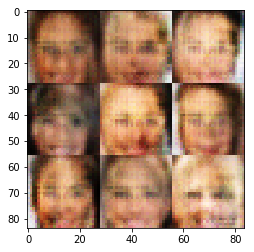

Epoch 1/2... Discriminator Loss: 1.4463... Generator Loss: 2.2502
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 1.2390


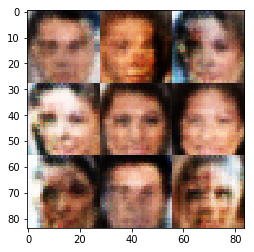

Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.2127... Generator Loss: 0.5945


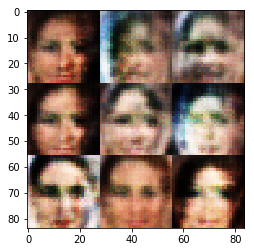

Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 0.8182
Epoch 1/2... Discriminator Loss: 1.0974... Generator Loss: 0.7930


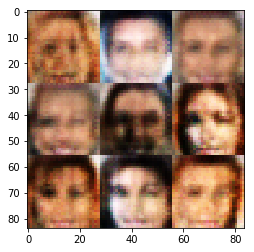

Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 0.7434
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 1.0322


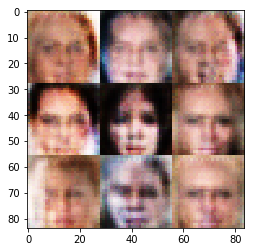

Epoch 1/2... Discriminator Loss: 1.4865... Generator Loss: 0.3963
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 2.3636


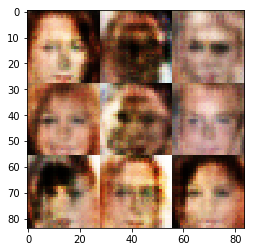

Epoch 1/2... Discriminator Loss: 1.0671... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 0.8331


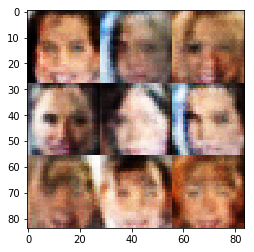

Epoch 1/2... Discriminator Loss: 1.0048... Generator Loss: 1.0116
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 0.8778


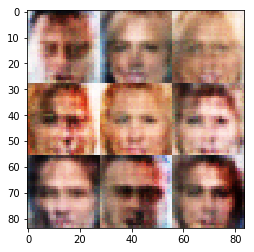

Epoch 1/2... Discriminator Loss: 1.1342... Generator Loss: 0.9394
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 0.8426


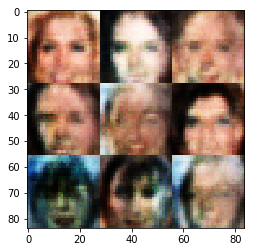

Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 1.5572
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 0.6766


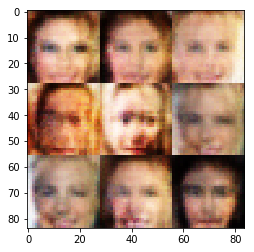

Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.5506
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 0.8264


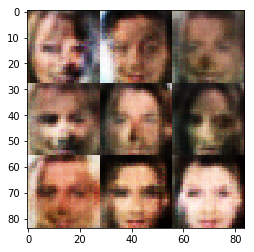

Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.5604


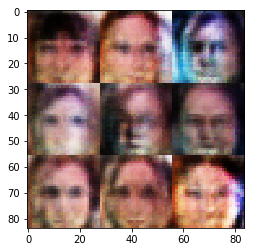

Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.5579


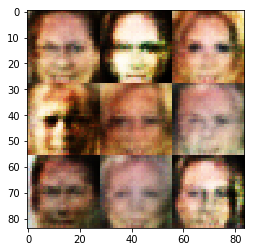

Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.8227
Epoch 1/2... Discriminator Loss: 1.6377... Generator Loss: 1.7554


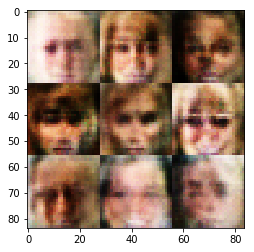

Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 0.6946... Generator Loss: 1.5995


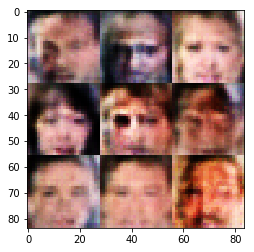

Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.4941
Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 0.8060


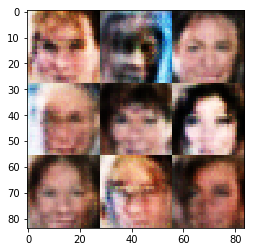

Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 1.0793
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 0.7753


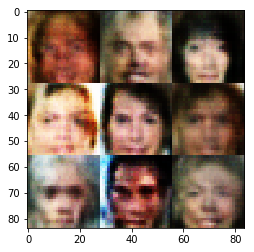

Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 2.2160


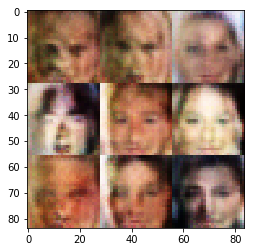

Epoch 1/2... Discriminator Loss: 0.8378... Generator Loss: 1.0973
Epoch 1/2... Discriminator Loss: 1.8029... Generator Loss: 0.2531


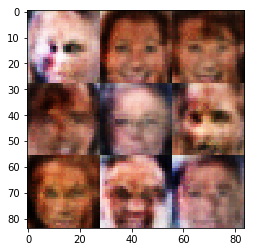

Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 1.9925
Epoch 1/2... Discriminator Loss: 1.7081... Generator Loss: 0.2915


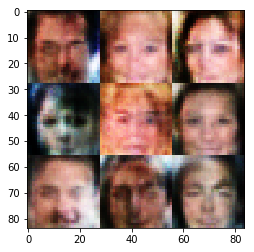

Epoch 1/2... Discriminator Loss: 0.6059... Generator Loss: 2.0881
Epoch 1/2... Discriminator Loss: 0.8065... Generator Loss: 1.5672


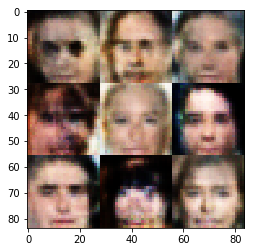

Epoch 1/2... Discriminator Loss: 0.7229... Generator Loss: 1.3082
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.4318


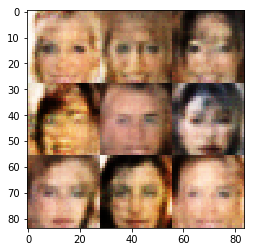

Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 0.4569
Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.3909


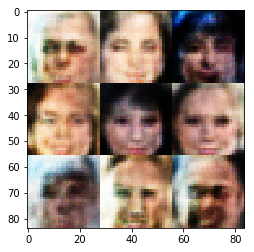

Epoch 1/2... Discriminator Loss: 1.8027... Generator Loss: 0.2296
Epoch 1/2... Discriminator Loss: 1.5143... Generator Loss: 0.3515


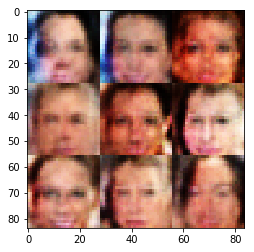

Epoch 1/2... Discriminator Loss: 0.4969... Generator Loss: 1.8650
Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 0.8423


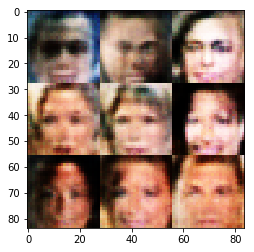

Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 1.5552... Generator Loss: 1.0613


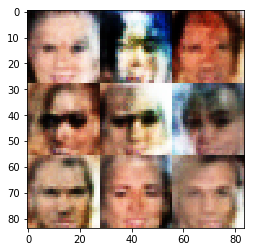

Epoch 1/2... Discriminator Loss: 0.4099... Generator Loss: 2.0595
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 3.8377


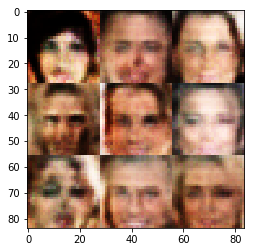

Epoch 1/2... Discriminator Loss: 0.8574... Generator Loss: 2.5452
Epoch 1/2... Discriminator Loss: 0.8916... Generator Loss: 1.6493


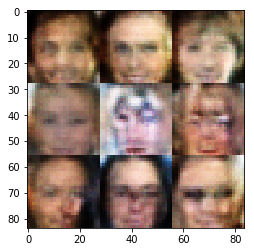

Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.1651
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.3762


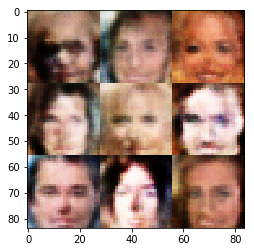

Epoch 1/2... Discriminator Loss: 0.5394... Generator Loss: 2.2952
Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 1.3434


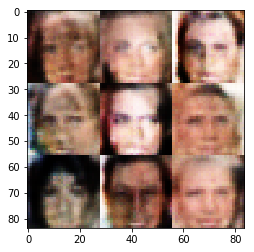

Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 0.9571... Generator Loss: 1.0537


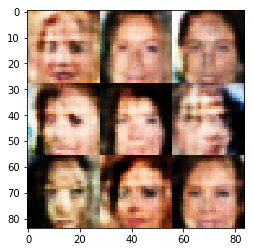

Epoch 2/2... Discriminator Loss: 1.7363... Generator Loss: 3.1192
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 2.1613


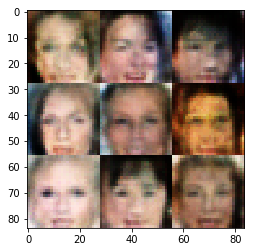

Epoch 2/2... Discriminator Loss: 1.7865... Generator Loss: 3.2233
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 3.0508


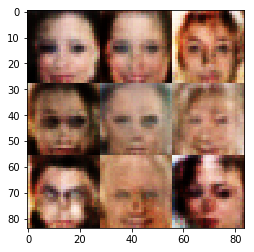

Epoch 2/2... Discriminator Loss: 0.7169... Generator Loss: 1.7816
Epoch 2/2... Discriminator Loss: 0.5380... Generator Loss: 1.8883


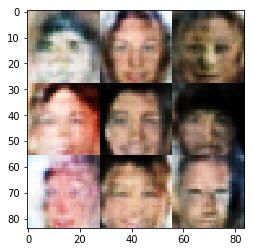

Epoch 2/2... Discriminator Loss: 0.5892... Generator Loss: 1.5165
Epoch 2/2... Discriminator Loss: 0.3720... Generator Loss: 2.7054


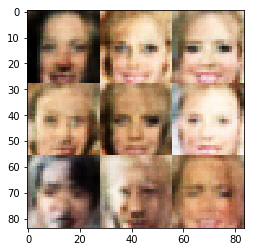

Epoch 2/2... Discriminator Loss: 0.5002... Generator Loss: 2.0473
Epoch 2/2... Discriminator Loss: 0.4674... Generator Loss: 1.8401


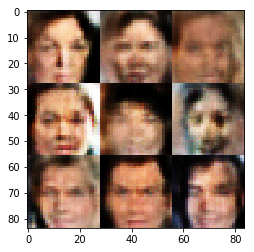

Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 2.7698


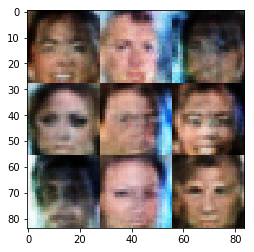

Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 1.1602
Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 0.6796


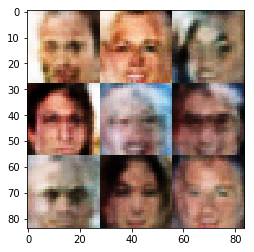

Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 1.7047
Epoch 2/2... Discriminator Loss: 0.6023... Generator Loss: 1.2646


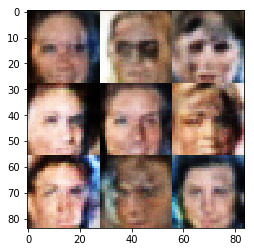

Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 0.6662
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 0.5131


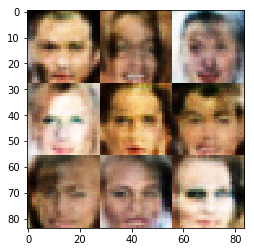

Epoch 2/2... Discriminator Loss: 0.7700... Generator Loss: 4.1299
Epoch 2/2... Discriminator Loss: 0.2371... Generator Loss: 2.3717


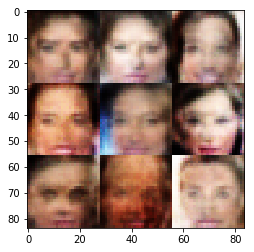

Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 2.3091


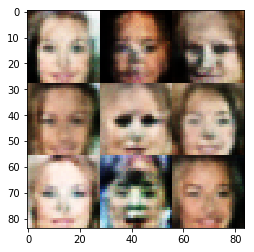

Epoch 2/2... Discriminator Loss: 0.5795... Generator Loss: 1.1231
Epoch 2/2... Discriminator Loss: 2.7579... Generator Loss: 2.3830


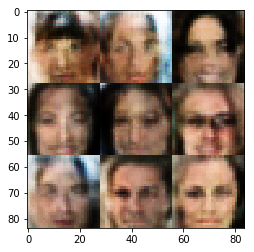

Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 3.0773
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 0.6692


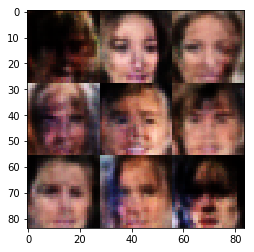

Epoch 2/2... Discriminator Loss: 0.6360... Generator Loss: 1.1742
Epoch 2/2... Discriminator Loss: 0.4689... Generator Loss: 2.5642


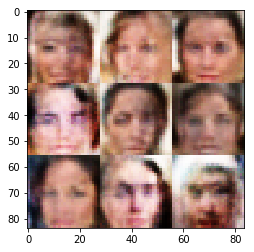

Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 2.7829
Epoch 2/2... Discriminator Loss: 0.8000... Generator Loss: 1.7077


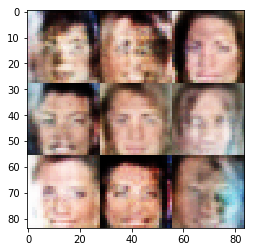

Epoch 2/2... Discriminator Loss: 0.3897... Generator Loss: 2.1791
Epoch 2/2... Discriminator Loss: 0.6186... Generator Loss: 4.6576


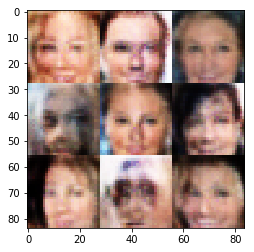

Epoch 2/2... Discriminator Loss: 0.2431... Generator Loss: 3.9742
Epoch 2/2... Discriminator Loss: 0.2399... Generator Loss: 3.5197


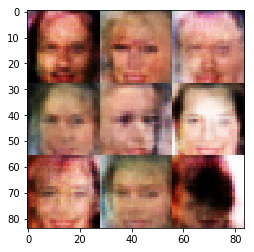

Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 0.4499
Epoch 2/2... Discriminator Loss: 0.3986... Generator Loss: 4.4891


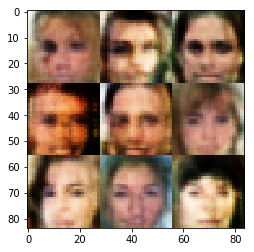

Epoch 2/2... Discriminator Loss: 1.1206... Generator Loss: 0.5992
Epoch 2/2... Discriminator Loss: 0.4725... Generator Loss: 1.4065


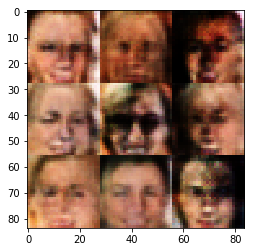

Epoch 2/2... Discriminator Loss: 1.0093... Generator Loss: 2.7885
Epoch 2/2... Discriminator Loss: 0.3991... Generator Loss: 1.6670


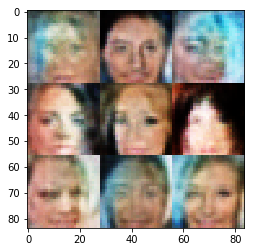

Epoch 2/2... Discriminator Loss: 0.4457... Generator Loss: 1.3410
Epoch 2/2... Discriminator Loss: 2.1672... Generator Loss: 3.2074


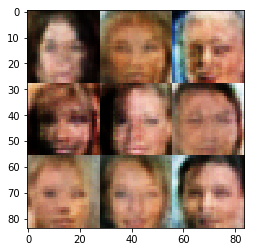

Epoch 2/2... Discriminator Loss: 0.3946... Generator Loss: 2.2331
Epoch 2/2... Discriminator Loss: 0.2478... Generator Loss: 2.0838


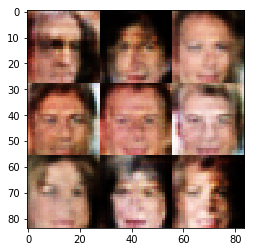

Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 0.5844
Epoch 2/2... Discriminator Loss: 0.2558... Generator Loss: 2.8129


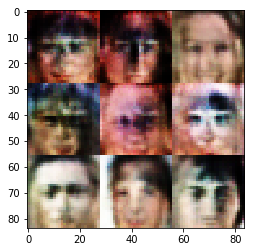

Epoch 2/2... Discriminator Loss: 0.4403... Generator Loss: 1.7383
Epoch 2/2... Discriminator Loss: 0.1678... Generator Loss: 2.7029


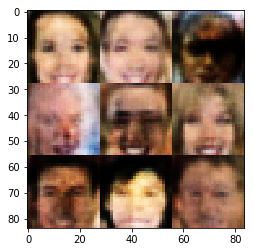

Epoch 2/2... Discriminator Loss: 3.1956... Generator Loss: 1.8448
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 1.4017


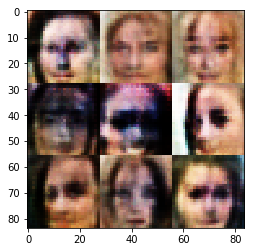

Epoch 2/2... Discriminator Loss: 0.4664... Generator Loss: 1.4022
Epoch 2/2... Discriminator Loss: 0.5138... Generator Loss: 2.6944


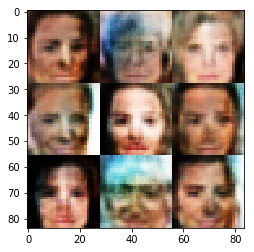

Epoch 2/2... Discriminator Loss: 1.5133... Generator Loss: 2.4772
Epoch 2/2... Discriminator Loss: 0.6063... Generator Loss: 1.5276


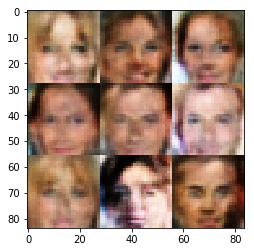

Epoch 2/2... Discriminator Loss: 0.3111... Generator Loss: 2.0907
Epoch 2/2... Discriminator Loss: 0.3731... Generator Loss: 1.5645


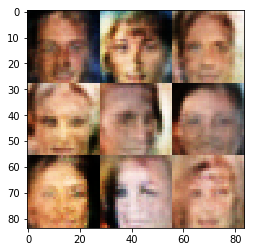

Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 1.4935
Epoch 2/2... Discriminator Loss: 0.5149... Generator Loss: 1.1852


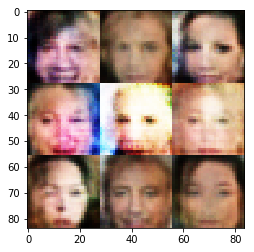

Epoch 2/2... Discriminator Loss: 0.2047... Generator Loss: 3.2649
Epoch 2/2... Discriminator Loss: 0.4443... Generator Loss: 1.4776


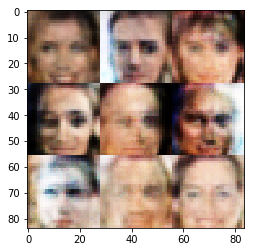

Epoch 2/2... Discriminator Loss: 0.7008... Generator Loss: 0.8497
Epoch 2/2... Discriminator Loss: 0.4274... Generator Loss: 3.9244


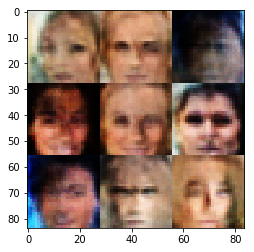

Epoch 2/2... Discriminator Loss: 0.6661... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 0.2370... Generator Loss: 2.6572


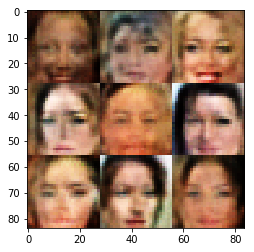

Epoch 2/2... Discriminator Loss: 0.7426... Generator Loss: 0.7759
Epoch 2/2... Discriminator Loss: 1.0626... Generator Loss: 0.6126


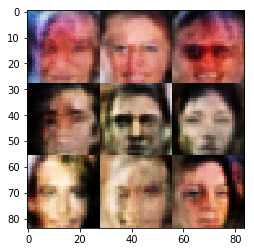

Epoch 2/2... Discriminator Loss: 0.3930... Generator Loss: 2.2557


IndexError: list index out of range

In [15]:
batch_size = 128

z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.